In [2]:
import torch
from einops import rearrange, repeat
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from pathlib import Path
from typing import List, Tuple, Dict
import seaborn as sns
from tqdm.auto import trange, tqdm

#kernels_out_mi_no_pool are from gentimmkernels.py

def load_kernel_files(directory="kernels_out_mi_no_pool"):
    """
    Load all .pt files from the specified directory.
    
    Args:
        directory (str): Directory containing kernel files
        
    Returns:
        dict: Dictionary mapping filenames to loaded kernel data
    """
    kernel_files = glob.glob(os.path.join(directory, "*.pt"))
    kernels = []
    names = []
    for file_path in tqdm(kernel_files):
        try:
            kernel_data = torch.load(file_path)

            K = kernel_data['K'].cuda() # this is the cosine kernel

            n = K.shape[0]
            ones = torch.ones(n, 1, device=K.device)
            H = torch.eye(n, device=K.device) - (1/n) * (ones @ ones.T)
            kernel = H @ K @ H
            
            #Fro norm
            kernel = kernel / torch.linalg.norm(kernel)

            #Trace norm
            #kernel = kernel / torch.trace(kernel)
            #kernel = kernel / torch.linalg.norm(kernel, ord='nuc')
            
            kernels.append(kernel.cpu())
            file_name = Path(file_path).stem
            names.append(file_name)

        except Exception as e:
            print(f"Error loading {file_path}: {e}")
    
    print(f"Loaded {len(kernels)} kernel files from {directory}")
    return kernels, names

# Load all kernel files
kernels, names = load_kernel_files()

  0%|          | 0/33 [00:00<?, ?it/s]

/tmp/ipykernel_4089/4079606029.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  kernel_data = torch.load(file_path)


Loaded 33 kernel files from kernels_out_mi_no_pool


In [3]:
def compute_expectation_variance(K: torch.Tensor,
                                 M: torch.Tensor,
                                 T: float = 1.0) -> Tuple[torch.Tensor,
                                                          torch.Tensor]:
    """Return Σ M σ and Σ M² σ(1‑σ) with σ = sigmoid(K/T)."""
    sigma       = torch.sigmoid(K / T)
    expectation = (M * sigma).sum()
    variance    = ((M**2) * sigma * (1 - sigma)).sum()
    return expectation, variance

In [4]:
import seaborn as sns

T = 0.01
expectations = np.zeros((len(kernels), len(kernels)))
variances = np.zeros((len(kernels), len(kernels)))
for i in trange(len(kernels)):
    for j in range(len(kernels)):
        K = kernels[i].cuda()
        M = kernels[j].cuda()
        expectation, variance = compute_expectation_variance(K, M, T)
        expectations[i, j] = expectation.cpu()
        variances[i, j] = variance.cpu()

  0%|          | 0/33 [00:00<?, ?it/s]

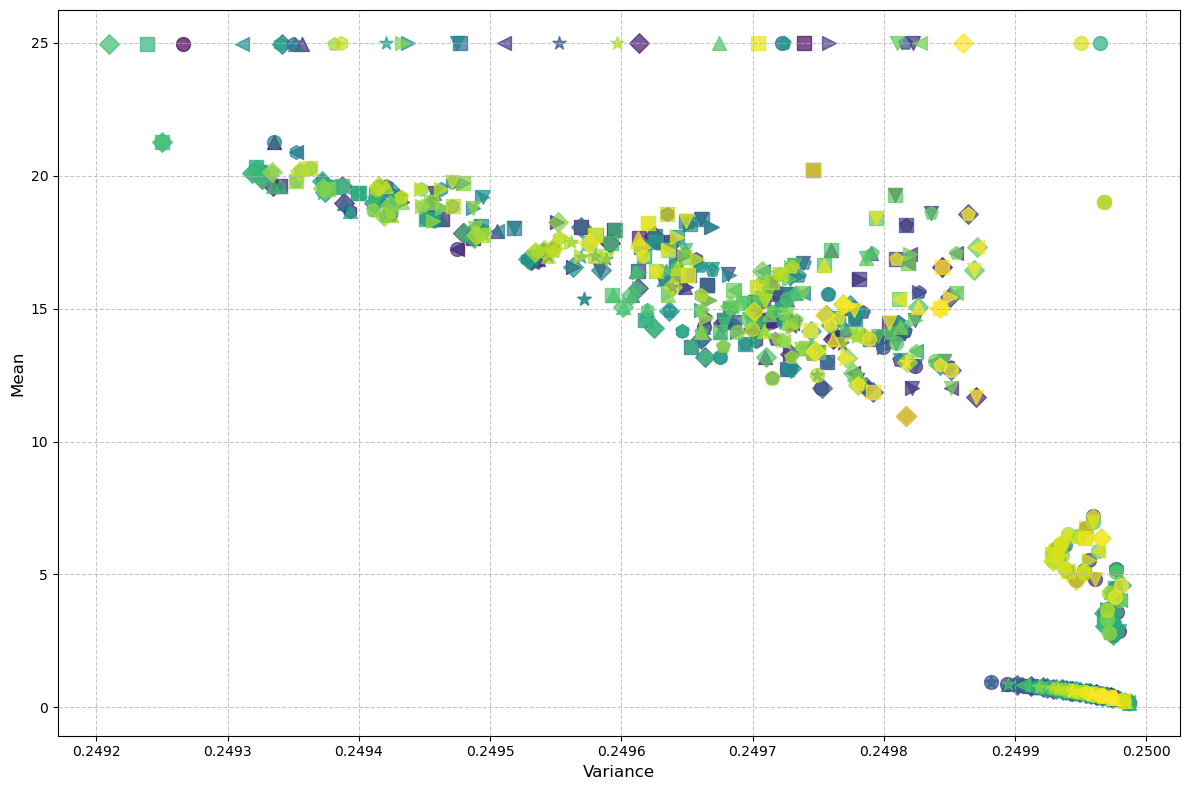

In [5]:
plt.figure(figsize=(12, 8))

markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'h']
colors = plt.cm.viridis(np.linspace(0, 1, len(kernels)))

plotted_K = set()
plotted_M = set()

for K_idx in range(len(kernels)):
    for M_idx in range(len(kernels)):
        y_val = expectations[K_idx, M_idx]
        x_val = variances[K_idx, M_idx]
        
        k_label = f"K: {names[K_idx]}" if names[K_idx] not in plotted_K else None
        if k_label:
            plotted_K.add(names[K_idx])
        
        plt.scatter(x_val, y_val, 
                    s=100,
                    color=colors[K_idx],
                    marker=markers[M_idx % len(markers)],
                    alpha=0.7,
                    label=k_label)

from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker=markers[i % len(markers)], color='gray', 
                         label=f"M: {names[i]}", markersize=10, linestyle='None')
                  for i in range(len(names))]

#first_legend = plt.legend(title="Kernel K (color)", bbox_to_anchor=(1.05, 1), loc='upper left')
#plt.gca().add_artist(first_legend)

#plt.legend(handles=legend_elements, title="Kernel M (marker)", 
#           bbox_to_anchor=(1.05, 0.5), loc='center left')

plt.ylabel('Mean', fontsize=12)
plt.xlabel('Variance', fontsize=12)
#plt.title('Relationship Between Variance and Expectation\nfor Different Kernel Combinations', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()

#save to pdf
plt.savefig("kernel_expectation_variance_comparision2.pdf", dpi=300, bbox_inches='tight')

plt.show()


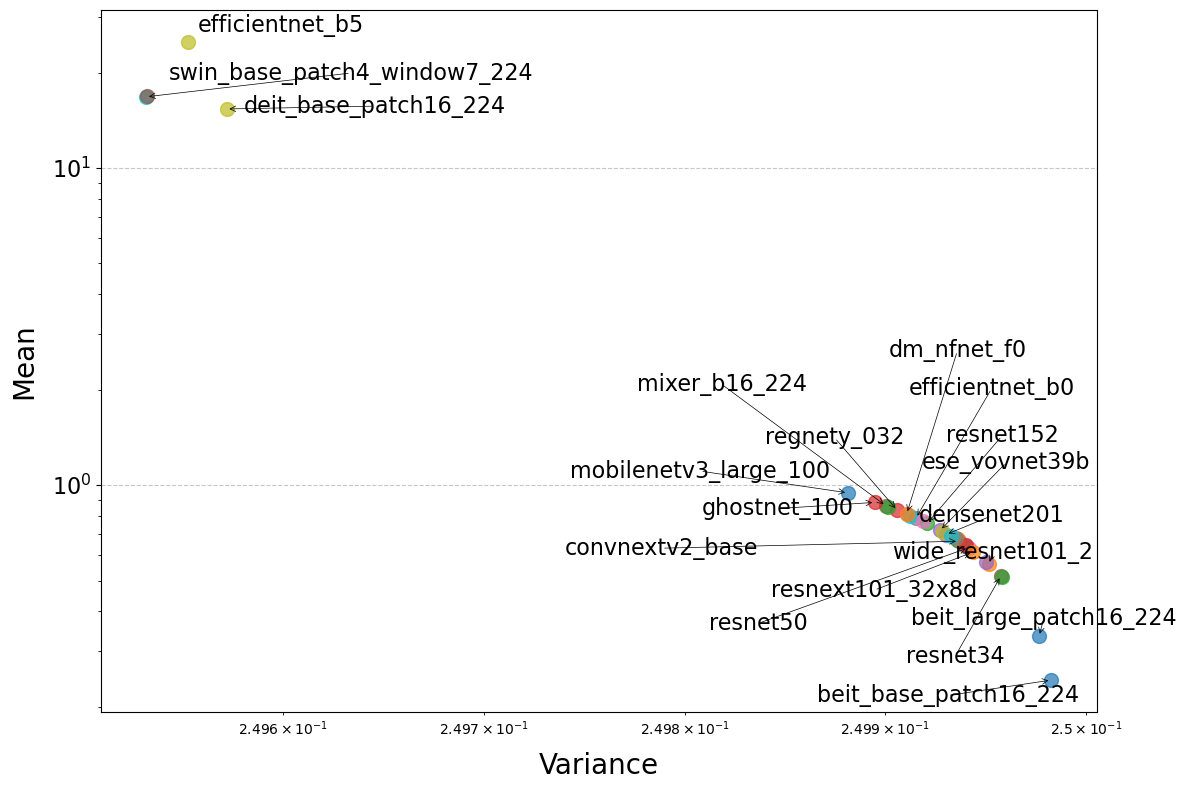

K_efficientnet_b5_8192


In [23]:
plt.figure(figsize=(12,8))

markers = ['o']
colors = plt.cm.viridis(np.linspace(0, 1, len(kernels)))

plotted_K = set()
plotted_M = set()

from adjustText import adjust_text
texts = []

K_idx = 8

# Control whether to drop dense labels or not
drop_dense_labels = True  # Set to False to show all labels

label_min_dist = 0.01  # in log-log space, tweak as needed
labeled_points = []

for M_idx in range(len(kernels)):
    y_val = expectations[K_idx, M_idx]
    x_val = variances[K_idx, M_idx]
    
    m_label = f"M: {names[M_idx]}" if names[M_idx] not in plotted_M else None
    if m_label:
        plotted_M.add(names[M_idx])
    
    plt.scatter(x_val, y_val, 
                s=100,
                marker=markers[K_idx % len(markers)],
                alpha=0.7,
                label=m_label)
    
    add_label = True
    if drop_dense_labels:
        # Only add a label if not too close to an already-labeled point
        log_x, log_y = np.log10(x_val), np.log10(y_val)
        for px, py in labeled_points:
            if np.hypot(log_x - px, log_y - py) < label_min_dist:
                add_label = False
                break
    # If not dropping dense labels, always add
    if add_label:
        model_name = names[M_idx].replace('K_', '').replace('_8192', '')
        texts.append(plt.text(x_val, y_val, model_name, fontsize=16))
        if drop_dense_labels:
            labeled_points.append((np.log10(x_val), np.log10(y_val)))
    # else: skip label for this point

from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker=markers[K_idx % len(markers)], color='gray', 
                         label=f"K: {names[K_idx]}", markersize=14, linestyle='None')]  # Increased markersize

#first_legend = plt.legend(title="Kernel M (color)", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=16, title_fontsize=18)  # Increased fontsize
#plt.gca().add_artist(first_legend)

plt.ylabel('Mean', fontsize=20, labelpad=10)
plt.xlabel('Variance', fontsize=20, labelpad=10)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True, linestyle='--', alpha=0.7)

plt.yscale('log')
plt.xscale('log')

if texts:
    adjust_text(texts, 
                arrowprops=dict(arrowstyle='->', color='black', lw=0.5),
                expand_points=(3.0, 3.0),
                force_points=(1.0, 1.0),
                force_text=(1.0, 1.0),
                only_move={'points':'xy', 'text':'xy'},
                fontsize=16)  # Increased fontsize for adjust_text
plt.savefig('kernel_variance_expectation_dropped.pdf', format='pdf', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()
print(names[K_idx])


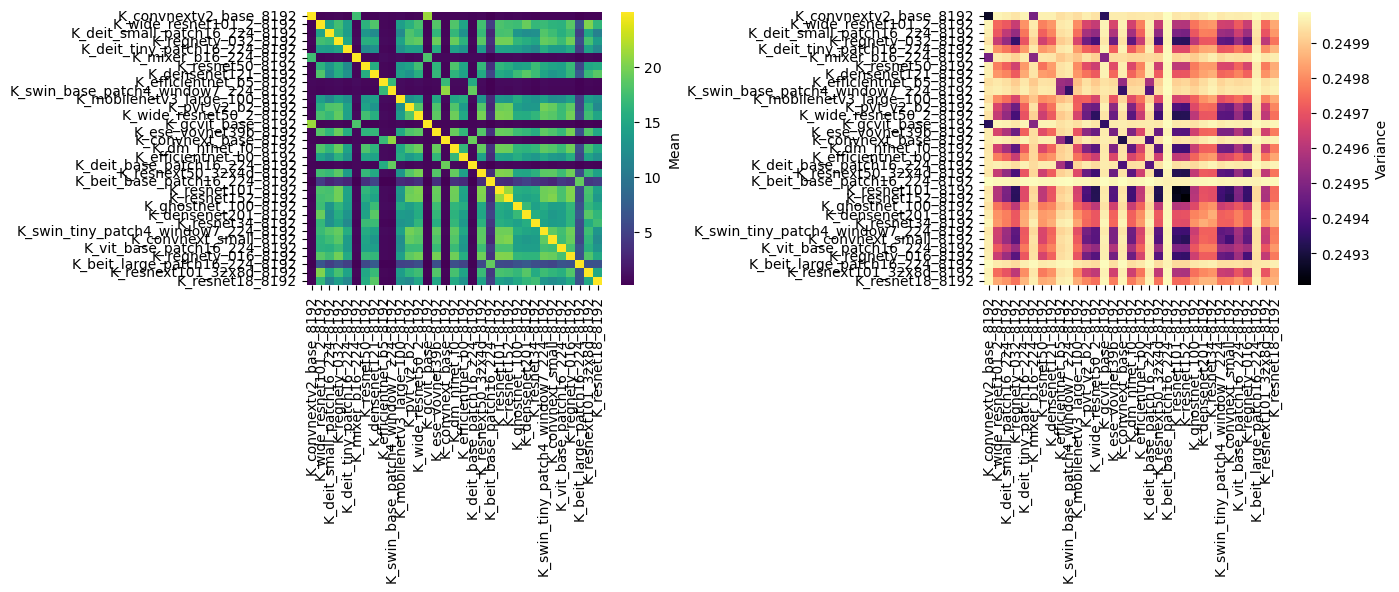

In [7]:
plt.figure(figsize=(14, 6))

# Expectation heatmap
plt.subplot(1, 2, 1)
sns.heatmap(expectations,
            xticklabels=names,
            yticklabels=names,
            cmap='viridis',
            cbar_kws={'label': 'Mean'})
plt.xticks(rotation=90)
plt.yticks(rotation=0)

# Variance heatmap
plt.subplot(1, 2, 2)
sns.heatmap(variances,
            xticklabels=names,
            yticklabels=names,
            cmap='magma',
            cbar_kws={'label': 'Variance'})
plt.xticks(rotation=90)
plt.yticks(rotation=0)

plt.tight_layout()

plt.savefig("kernel_comparision_heatmaps.pdf", dpi=300, bbox_inches='tight')
plt.show()

In [8]:
#These are from check_lin_probes.ipynb

names2 =['K_deit_tiny_patch16_224_8192', 'K_deit_small_patch16_224_8192',
       'K_pvt_v2_b2_8192', 'K_resnet34_8192', 'K_resnet18_8192',
       'K_beit_base_patch16_224_8192', 'K_convnext_small_8192',
       'K_vit_base_patch16_224_8192', 'K_mixer_b16_224_8192',
       'K_swin_tiny_patch4_window7_224_8192', 'K_regnety_016_8192',
       'K_beit_large_patch16_224_8192', 'K_gcvit_base_8192',
       'K_convnextv2_base_8192', 'K_ese_vovnet39b_8192',
       'K_densenet121_8192', 'K_ghostnet_100_8192',
       'K_efficientnet_b0_8192', 'K_mobilenetv3_large_100_8192',
       'K_regnety_032_8192', 'K_densenet201_8192', 'K_resnet152_8192',
       'K_resnet101_8192', 'K_wide_resnet50_2_8192',
       'K_resnext50_32x4d_8192', 'K_resnext101_32x8d_8192',
       'K_wide_resnet101_2_8192', 'K_resnet50_8192', 'K_dm_nfnet_f0_8192',
       'K_deit_base_patch16_224_8192',
       'K_swin_base_patch4_window7_224_8192', 'K_convnext_base_8192',
       'K_efficientnet_b5_8192']

lin_acc = [57.79088593, 59.82952118, 60.96138   , 60.96542358, 61.2118988 ,
       62.85617828, 63.20861816, 63.28761292, 63.32206726, 63.41498566,
       63.83324432, 64.92811584, 65.0249939 , 65.08885956, 65.25717926,
       65.40444946, 66.19694519, 67.00268555, 67.18942261, 68.43959045,
       71.58625793, 71.6837616 , 71.7747345 , 71.82046509, 72.16220093,
       72.16519928, 72.1867981 , 72.19929504, 78.36734009, 79.12139893,
       80.704422  , 81.01097107, 88.83001709]

lin_var = [632.11882424, 369.68042915, 276.12709021, 230.92837963,
       230.86740236, 233.90708279, 212.48722309, 170.50046497,
       171.89950712, 171.44990519, 164.98461173, 127.42224255,
       152.19137527, 150.22586249, 111.95788137, 105.64870991,
        90.49537899,  81.2927986 ,  81.37823127,  70.92459899,
        38.45466723,  52.72400468,  48.06554259,  45.87425862,
        48.4695183 ,  38.75932142,  40.56234485,  41.81197057,
        19.0132818 ,   6.65209361,   3.86893889,   5.2107294 ,
         4.3978428 ]

In [9]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score
import numpy as np
from scipy.stats import pearsonr

def check_pearsons(K_index, verbose=False):
    df = pd.DataFrame()
    df['names'] = names
    df['tr_var'] = variances[K_index,:]
    df['tr_exp'] = expectations[K_index,:]
    df['tr_var'] = np.log(variances[K_index,:])
    df['tr_exp'] = np.log(expectations[K_index,:])

    df2 = pd.DataFrame()
    df2['names'] = names2
    df2['lnacc'] = lin_acc
    df2['lnvar'] = lin_var
    
    common_names = list(set(df['names']).intersection(set(df2['names'])))

    df_both = pd.DataFrame()
    df_both['names'] = common_names

    for name in common_names:
        df_idx = df[df['names'] == name].index[0]
        df_both.loc[df_both['names'] == name, 'tr_exp'] = df.loc[df_idx, 'tr_exp']
        df_both.loc[df_both['names'] == name, 'tr_var'] = df.loc[df_idx, 'tr_var']

    for name in common_names:
        df2_idx = df2[df2['names'] == name].index[0]
        df_both.loc[df_both['names'] == name, 'lnacc'] = df2.loc[df2_idx, 'lnacc']
        df_both.loc[df_both['names'] == name, 'lnvar'] = df2.loc[df2_idx, 'lnvar']

    r2_acc_exp = r2_score(df_both['lnacc'], df_both['tr_exp'])
    r2_var = r2_score(df_both['lnvar'], df_both['tr_var'])

    pearson_acc_exp, p_value_acc = pearsonr(df_both['lnacc'], df_both['tr_exp'])
    pearson_var, p_value_var = pearsonr(df_both['lnvar'], df_both['tr_var'])

    if verbose:
        print(f"R^2 between linear accuracy and trace of exponential: {r2_acc_exp:.4f}")
        print(f"Pearson correlation (accuracy vs trace exp): {pearson_acc_exp:.4f}, p-value: {p_value_acc:.4e}")
        print(f"R^2 between linear variance and trace variance: {r2_var:.4f}")
        print(f"Pearson correlation (variance vs trace variance): {pearson_var:.4f}, p-value: {p_value_var:.4e}")

        import matplotlib.pyplot as plt
        from scipy import stats

        plt.figure(figsize=(5, 10))

        plt.subplot(2, 1, 1)
        plt.scatter(df_both['tr_exp'], df_both['lnacc'])

        # Add line of best fit with confidence intervals
        slope, intercept, r_value, p_value, std_err = stats.linregress(df_both['tr_exp'], df_both['lnacc'])
        x_range = np.linspace(min(df_both['tr_exp']), max(df_both['tr_exp']), 100)
        y_pred = intercept + slope * x_range
        
        # Calculate prediction intervals
        n = len(df_both)
        x_mean = np.mean(df_both['tr_exp'])
        t_value = stats.t.ppf(0.975, n-2)  # 95% confidence interval
        s_err = np.sqrt(np.sum((df_both['lnacc'] - (intercept + slope * df_both['tr_exp']))**2) / (n-2))
        
        # Standard error of the regression line
        conf = t_value * s_err * np.sqrt(1/n + (x_range - x_mean)**2 / np.sum((df_both['tr_exp'] - x_mean)**2))
        
        # Plot regression line and confidence intervals
        plt.plot(x_range, y_pred, 'r-', color='gray')
        plt.fill_between(x_range, y_pred - conf, y_pred + conf, color='gray', alpha=0.2)

        ax = plt.gca()
        from matplotlib.ticker import MaxNLocator
        ax.xaxis.set_major_locator(MaxNLocator(nbins=5))  

        plt.xlabel('Log Trace Average')
        plt.ylabel('Linear Probe Accuracy')
        plt.title(f'Pearson r={pearson_acc_exp:.4f}')

        
        plt.subplot(2, 1, 2)
        plt.scatter(df_both['tr_var'], df_both['lnvar'])

        # Add line of best fit with confidence intervals
        slope, intercept, r_value, p_value, std_err = stats.linregress(df_both['tr_var'], df_both['lnvar'])
        x_range = np.linspace(min(df_both['tr_var']), max(df_both['tr_var']), 100)
        y_pred = intercept + slope * x_range
        
        # Calculate prediction intervals
        n = len(df_both)
        x_mean = np.mean(df_both['tr_var'])
        t_value = stats.t.ppf(0.975, n-2)  # 95% confidence interval
        s_err = np.sqrt(np.sum((df_both['lnvar'] - (intercept + slope * df_both['tr_var']))**2) / (n-2))
        
        # Standard error of the regression line
        conf = t_value * s_err * np.sqrt(1/n + (x_range - x_mean)**2 / np.sum((df_both['tr_var'] - x_mean)**2))
        
        # Plot regression line and confidence intervals
        plt.plot(x_range, y_pred, 'r-', color='gray')
        plt.fill_between(x_range, y_pred - conf, y_pred + conf, color='gray', alpha=0.2)


        ax = plt.gca()
        ax.xaxis.set_major_locator(MaxNLocator(nbins=5))  # You can adjust the number of ticks

        plt.xlabel('Log Trace Variance')
        plt.ylabel('Linear Probe Variance')
        plt.title(f'Pearson r={pearson_var:.4f}')

        plt.tight_layout()

        plt.savefig(f'{names[K_index]}_pearson.pdf', format='pdf', dpi=300, bbox_inches='tight')
        
        plt.show()

    return pearson_acc_exp, pearson_var

R^2 between linear accuracy and trace of exponential: -95.9352
Pearson correlation (accuracy vs trace exp): 0.7815, p-value: 7.9425e-08
R^2 between linear variance and trace variance: -1.0647
Pearson correlation (variance vs trace variance): 0.4198, p-value: 1.5005e-02


/tmp/ipykernel_4089/1210751287.py:70: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(x_range, y_pred, 'r-', color='gray')
/tmp/ipykernel_4089/1210751287.py:100: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(x_range, y_pred, 'r-', color='gray')


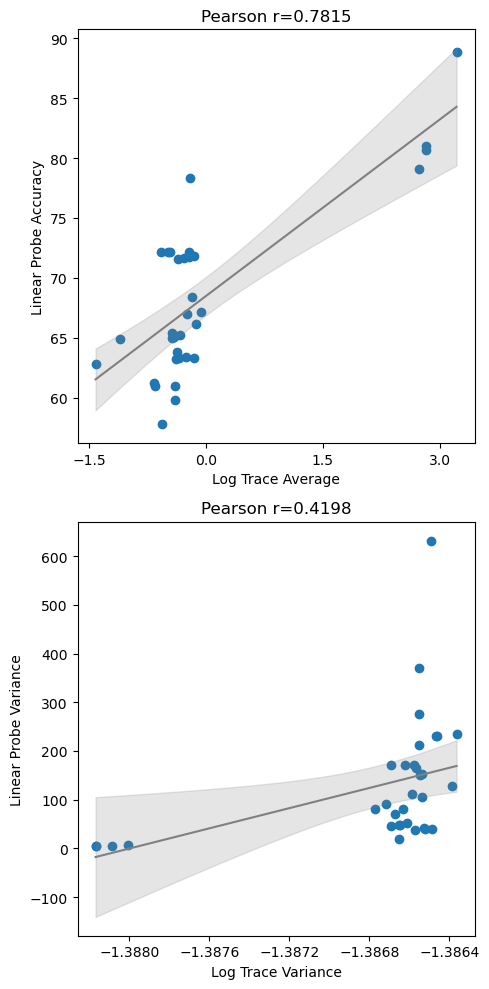

(0.7815185910054262, 0.41982038807384164)

In [10]:
check_pearsons(8, verbose = True)